# Final Proejct

In [128]:
import numpy as np
import matplotlib.pyplot as plt

In [129]:
# Classic GBM
def GBM(S0, mu, sigma, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N + 1)
    W = np.random.normal(0, np.sqrt(dt), N + 1)
    W[0] = 0
    W = np.cumsum(W)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S, t

In [130]:
# # Linear increasing/decreasing volatility
# def sigma_linear(t, sigma0=0.2, sigma1=0.4):
#     return sigma0 + (sigma1 - sigma0) * t

# # Seasonal/cyclical volatility
# def sigma_seasonal(t, sigma0=0.2, amplitude=0.1, period=1.0):
#     return sigma0 + amplitude * np.sin(2 * np.pi * t / period)

# # Step function volatility
# def sigma_stepwise(t, sigma0=0.2, sigma1=0.4, change_point=0.5):
#     return np.where(t < change_point, sigma0, sigma1)

In [131]:
# Linear volatility
def sigma_linear(t, sigma0=0.2, sigma1=0.4, sigma2=0.1, num_changes=2, change_points=None):
    if change_points is None:
        change_points = np.sort(np.random.uniform(0, 1, num_changes))
    conditions = [t < change_points[0]]
    values = [sigma0 + (sigma1 - sigma0) * (t / change_points[0])]
    for i in range(1, len(change_points)):
        conditions.append((t >= change_points[i-1]) & (t < change_points[i]))
        next_sigma = sigma2 if i == len(change_points) - 1 else sigma1
        values.append(next_sigma + (sigma2 - next_sigma) * ((t - change_points[i-1]) / (change_points[i] - change_points[i-1])))
    conditions.append(t >= change_points[-1])
    values.append(sigma2 + (sigma0 - sigma2) * ((t - change_points[-1]) / (1 - change_points[-1])))
    return np.select(conditions, values)

# Seasonal volatility
def sigma_seasonal(t, sigma0=0.2, amplitude=0.1, period=1.0, cycles=None):
    if cycles is None:
        cycles = np.random.poisson(2) + 1  # Ensure nonzero cycle count
    return sigma0 + amplitude * np.sin(2 * np.pi * cycles * t / period)

# Stepwise volatility
def sigma_stepwise(t, sigmas=[0.2, 0.4], num_changes=2, change_points=None):
    if change_points is None:
        change_points = np.sort(np.random.uniform(0, 1, num_changes))
    conditions = [t < change_points[0]]
    values = [sigmas[0]]
    for i in range(1, len(change_points)):
        conditions.append((t >= change_points[i-1]) & (t < change_points[i]))
        values.append(sigmas[i % len(sigmas)])
    conditions.append(t >= change_points[-1])
    values.append(sigmas[len(change_points) % len(sigmas)])
    return np.select(conditions, values)

In [132]:
# GBM with time-varying volatility
def GBM_timevarying(S0, mu, sigma_func, T, dt, *args, **kwargs):
    N = int(T / dt)
    t = np.linspace(0, T, N+1)
    sigma_t = sigma_func(t[:-1], *args, **kwargs)  # Forwarding additional parameters
    W = np.random.normal(0, np.sqrt(dt), N)
    W = np.insert(W, 0, 0)
    W_cum = np.cumsum(W)

    drift = (mu - 0.5 * sigma_t**2) * dt
    diffusion = sigma_t * W[1:]

    drift = np.insert(np.cumsum(drift), 0, 0)
    diffusion = np.insert(np.cumsum(diffusion), 0, 0)

    S = S0 * np.exp(drift + diffusion)
    return S, t

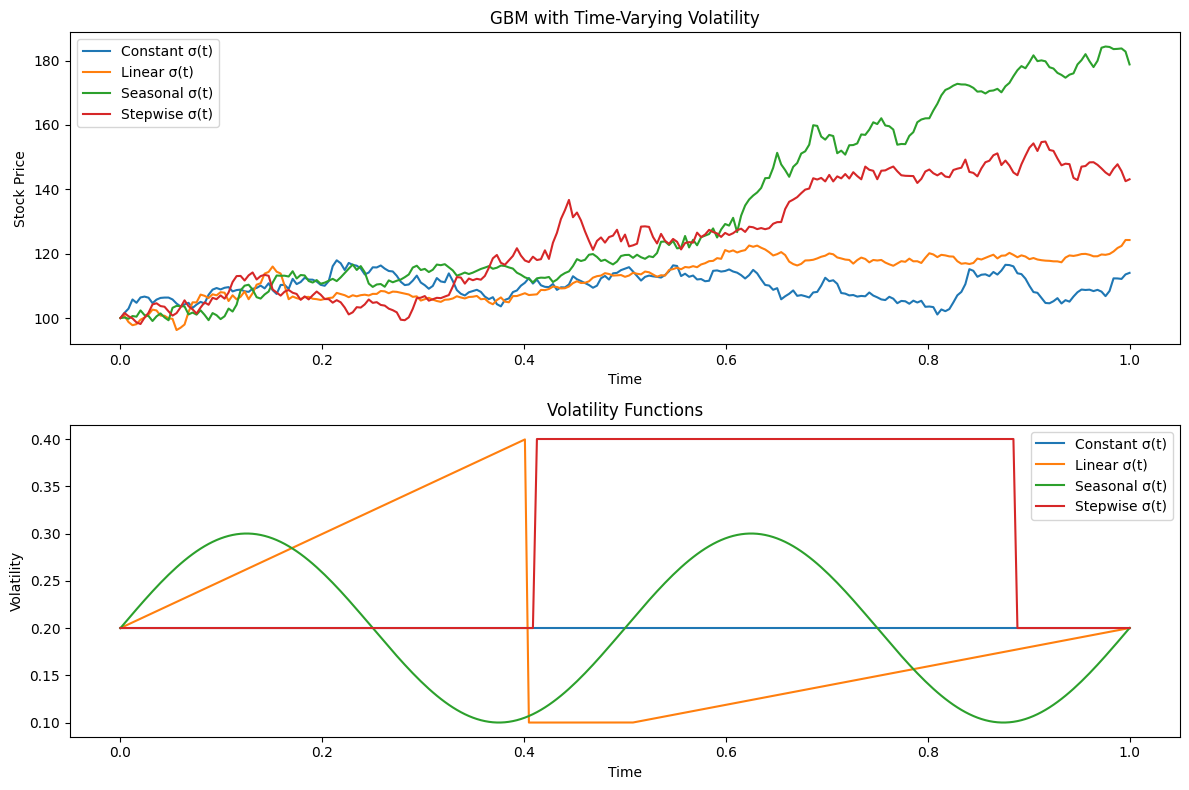

In [162]:
# Simulation setup
S0 = 100
mu = 0.08
T = 1.0
dt = 1/252
sigma = 0.2 # Constant volatility

# Parameters for volatility functions
num_changes_linear = 2
num_cycles_seasonal = 2
num_changes_stepwise = 2

# Generate paths
S_constant, t = GBM(S0, mu, sigma, T, dt)
S_linear, _ = GBM_timevarying(S0, mu, sigma_linear, T, dt, num_changes=num_changes_linear)
S_seasonal, _ = GBM_timevarying(S0, mu, sigma_seasonal, T, dt, cycles=num_cycles_seasonal)
S_stepwise, _ = GBM_timevarying(S0, mu, sigma_stepwise, T, dt, num_changes=num_changes_stepwise)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, S_constant, label='Constant σ(t)')
plt.plot(t, S_linear, label='Linear σ(t)')
plt.plot(t, S_seasonal, label='Seasonal σ(t)')
plt.plot(t, S_stepwise, label='Stepwise σ(t)')
plt.title('GBM with Time-Varying Volatility')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, np.array([sigma] * len(t)), label='Constant σ(t)')
plt.plot(t, sigma_linear(t, num_changes=num_changes_linear), label='Linear σ(t)')
plt.plot(t, sigma_seasonal(t, cycles=num_cycles_seasonal), label='Seasonal σ(t)')
plt.plot(t, sigma_stepwise(t, num_changes=num_changes_stepwise), label='Stepwise σ(t)')
plt.title('Volatility Functions')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def heston_model(S0, sigma0, mu, lambda_, sigmabar, xi, rho, T, dt):
    N = int(T/dt)
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    variance = np.zeros(N+1)
    S[0] = S0
    variance[0] = sigma0**2

    dW_S = np.random.normal(0, np.sqrt(dt), N)
    dW_variance = np.random.normal(0, np.sqrt(dt), N)
    dW_variance = rho * dW_S + np.sqrt(1 - rho**2) * dW_variance

    for i in range(1, N+1):
        variance[i] = variance[i-1] + lambda_ * (sigmabar**2 - variance[i-1]) * dt + xi * np.sqrt(max(variance[i-1], 0)) * dW_variance[i-1]
        S[i] = S[i-1] + mu * S[i-1] * dt + np.sqrt(max(variance[i-1], 0)) * S[i-1] * dW_S[i-1]

    return S, np.sqrt(variance), t

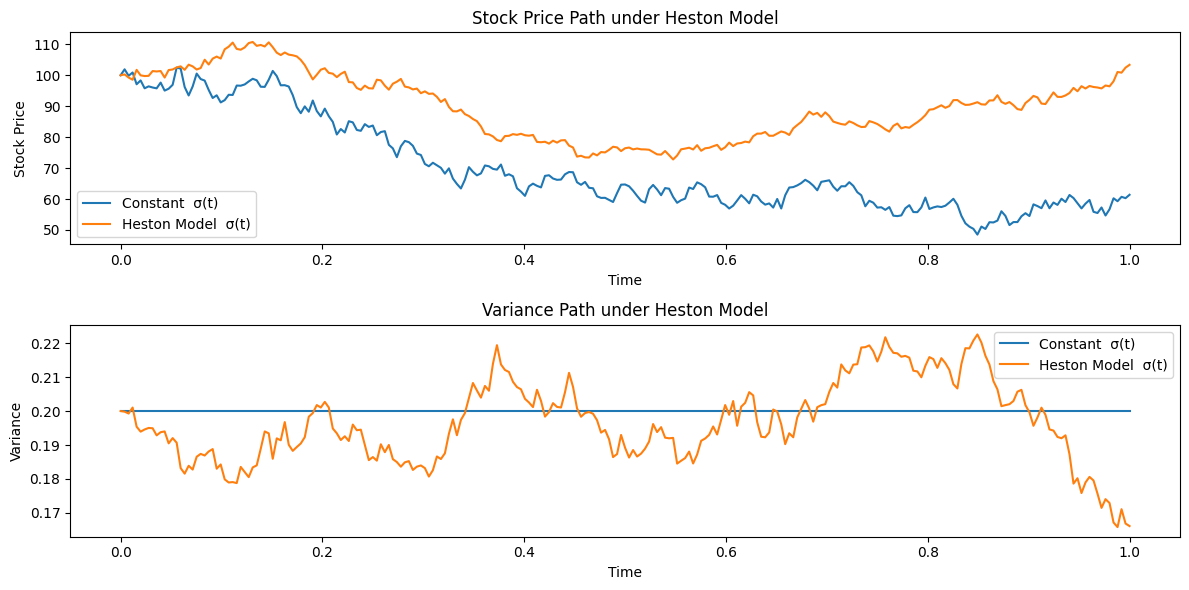

In [163]:
# Model parameters
S0 = 100
sigma0 = 0.2        # Initial vol
mu = 0.08
lambda_ = 0.2       # Mean reversion rate
sigmabar = 0.2      # Long-term vol
xi = 0.1            # Volatility of vol
rho = -0.2          # Stock-vol correlation
T = 1.0
dt = 1/252

# Generate paths
S_heston, variance, t = heston_model(S0, sigma0, mu, lambda_, sigmabar, xi, rho, T, dt)
S_constant, _ = GBM(S0, mu, np.sqrt(sigmabar), T, dt)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, S_constant, label='Constant  σ(t)')
plt.plot(t, S_heston, label='Heston Model  σ(t)')
plt.title('Stock Price Path under Heston Model')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, sigmabar * np.ones(len(t)), label='Constant  σ(t)')
plt.plot(t, variance, label='Heston Model  σ(t)')
plt.title('Variance Path under Heston Model')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.tight_layout()
plt.show()

In [159]:
def garch_volatility(N, sigma0, kappa, sigma_bar, alpha, z):
    """ Generate GARCH(1,1) volatility path using N+1 points including the starting point. """
    sigma2 = np.zeros(N+1)
    sigma2[0] = sigma0**2

    for i in range(1, N+1):
        sigma2[i] = kappa * sigma_bar**2 + (1 - kappa - alpha) * sigma2[i-1] + alpha * z[i-1]**2 * sigma2[i-1]

    return np.sqrt(sigma2)

def GBM_garch(S0, mu, sigma0, kappa, sigma_bar, alpha, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    S[0] = S0
    z = np.random.normal(0, 1, N)
    sigma_t = garch_volatility(N, sigma0, kappa, sigma_bar, alpha, z)
    
    dW = np.random.normal(0, np.sqrt(dt), N)

    for i in range(1, N+1):
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma_t[i-1]**2) * dt + sigma_t[i-1] * dW[i-1])

    return S, sigma_t, t

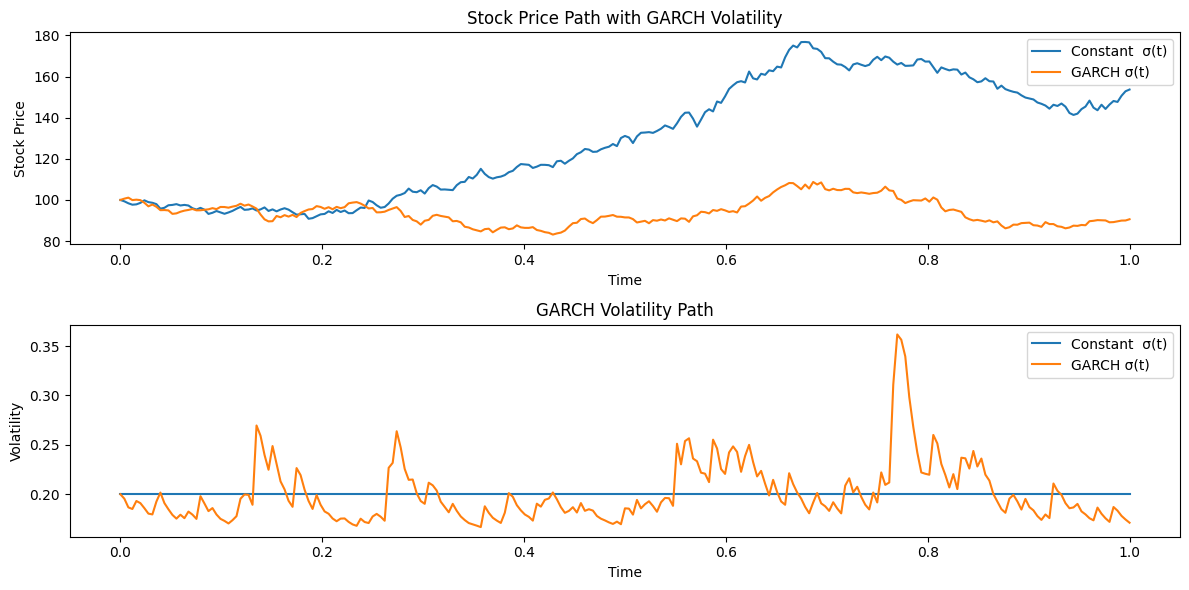

In [164]:
S0 = 100
mu = 0.08
sigma0 = 0.2       # Initial vol
kappa = 0.2        # Mean reversion coefficient
sigma_bar = 0.2    # Long term vol
alpha = 0.1        # GARCH reaction coefficient
T = 1.0
dt = 1/252

# Generate paths
S_garch, sigma_garch, t = GBM_garch(S0, mu, sigma0, kappa, sigma_bar, alpha, T, dt)
S_constant, _ = GBM(S0, mu, sigma_bar, T, dt)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, S_constant, label='Constant  σ(t)')
plt.plot(t, S_garch, label='GARCH σ(t)')
plt.title('Stock Price Path with GARCH Volatility')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, sigmabar * np.ones(len(t)), label='Constant  σ(t)')
plt.plot(t, sigma_garch, label='GARCH σ(t)')
plt.title('GARCH Volatility Path')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

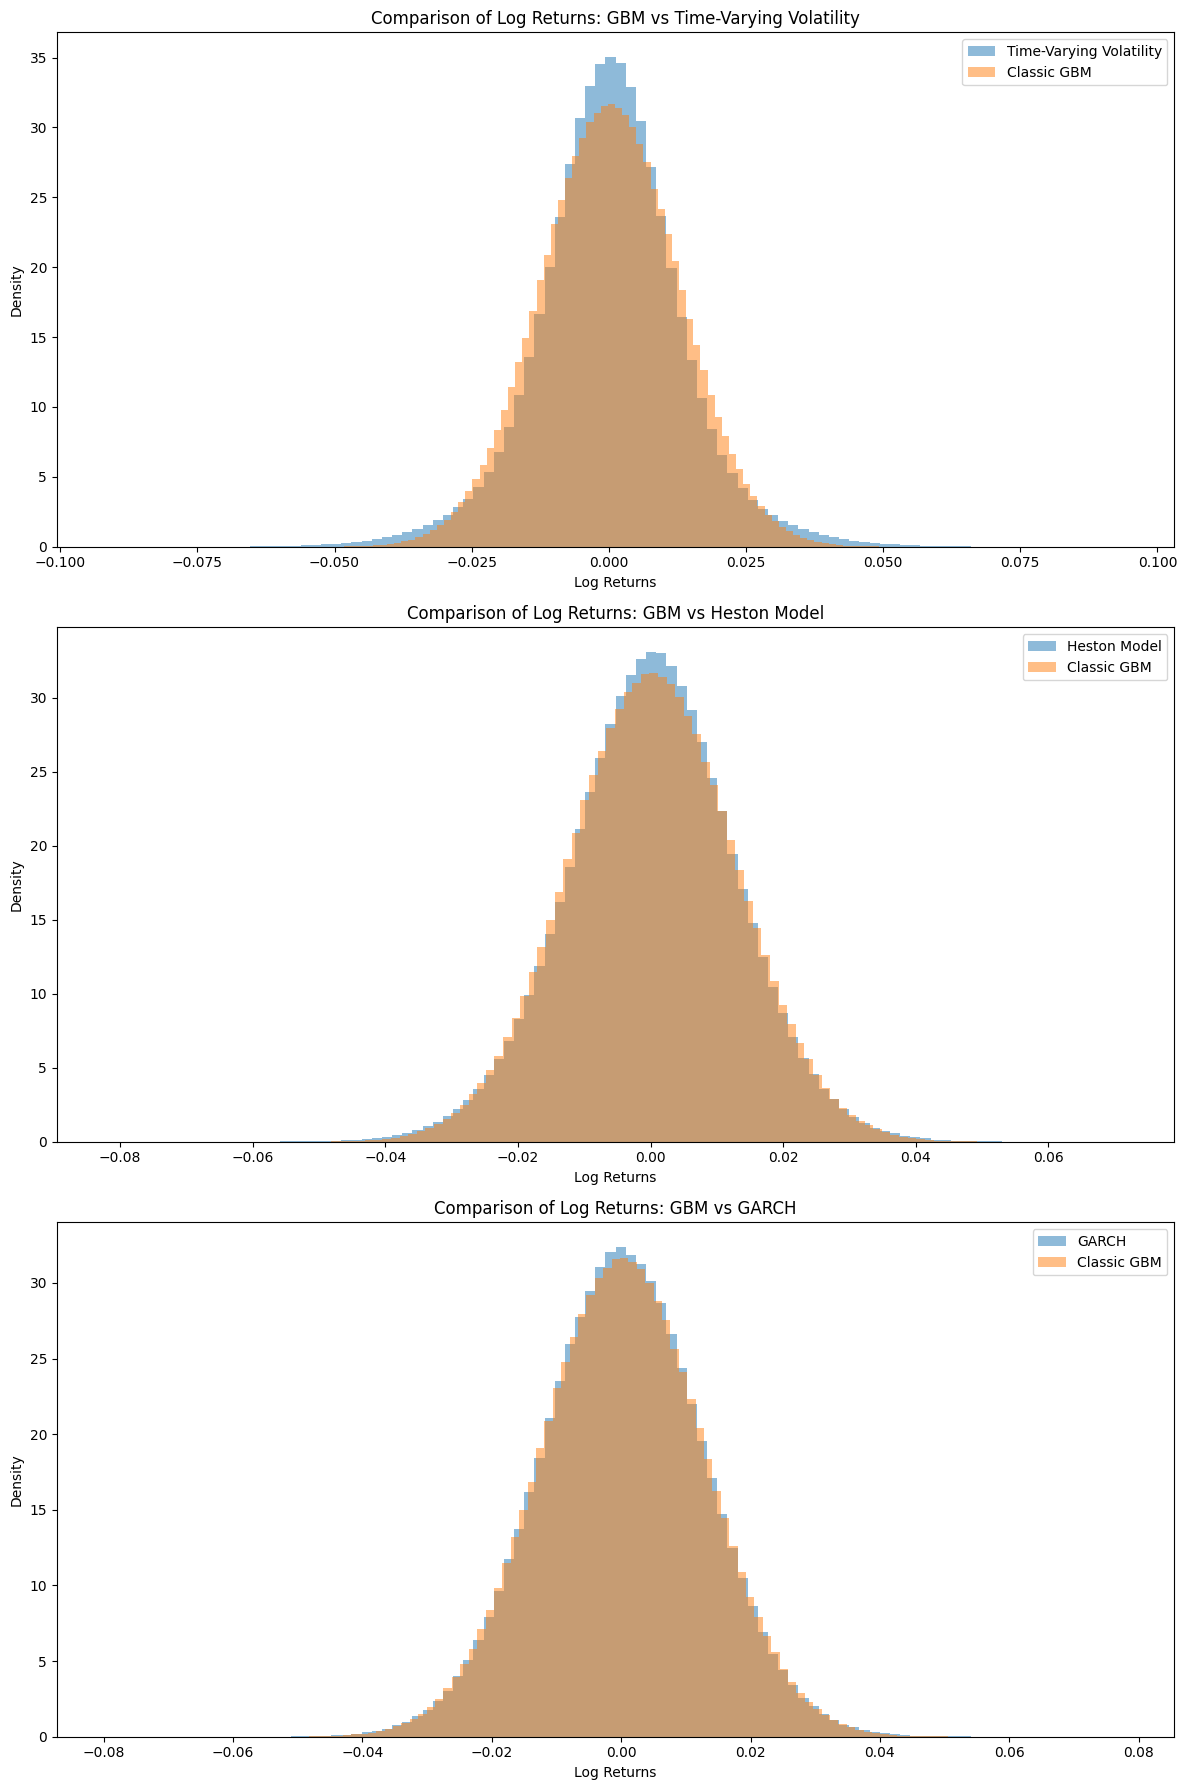

In [ ]:
# Log returns calculator
def calculate_log_returns(S):
    return np.log(S[1:] / S[:-1])

# Monte Carlo simulation function
def monte_carlo_simulation(S0, mu, sigma, T, dt, num_paths, model, **kwargs):
    N = int(T / dt)
    all_S = np.zeros((num_paths, N + 1))
    all_log_returns = np.zeros((num_paths, N))

    for i in range(num_paths):
        if model == 'classic_gbm':
            S, _ = GBM(S0, mu, sigma, T, dt)
        elif model == 'garch':
            S, _, _ = GBM_garch(S0, mu, kwargs['sigma0'], kwargs['kappa'], kwargs['sigma_bar'], kwargs['alpha'], T, dt)
        elif model == 'time_varying':
            S, _ = GBM_timevarying(S0, mu, kwargs['sigma_func'], T, dt, **kwargs['sigma_func_params'])
        elif model == 'heston':
            S, _, _ = heston_model(S0, kwargs['sigma0'], mu, kwargs['lambda_'], kwargs['sigmabar'], kwargs['xi'], kwargs['rho'], T, dt)
        
        all_S[i] = S
        all_log_returns[i] = calculate_log_returns(S)

    return all_log_returns

# General parameters
num_paths = 10000
S0 = 100        # Initial stock price for all models
mu = 0.08       # Drift rate for all models
T = 1.0         # Total time for all models
dt = 1/252      # Time step

# Classic GBM parameters
sigma_constant = 0.2  # Constant vol

# Time-varying volatility (Stepwise func) parameters
num_jumps = 2  # Number of jumps
low_vol = 0.15  # Low volatility
high_vol = 0.3 # High volatility

# Heston model parameters
lambda_heston = 0.2     # Mean reversion rate 
sigmabar_heston = 0.2   # Long-term volatility
xi_heston = 0.1         # Volatility of vol
rho_heston = -0.2       # Correlation between stock and variance

# GARCH model parameters
kappa_garch = 0.2       # Mean reversion coefficient
sigma_bar_garch = 0.2   # Long term volatility 
alpha_garch = 0.1       # Reaction coefficient 

# Monte Carlo simulations
log_returns_constant = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'classic_gbm')
log_returns_garch = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'garch', sigma0=sigma0, kappa=kappa_garch, sigma_bar=sigma_bar_garch, alpha=alpha_garch)
log_returns_time_varying = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'time_varying', sigma_func=sigma_stepwise, sigma_func_params={'num_changes': num_jumps, 'sigmas': [low_vol, high_vol]})
log_returns_heston = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'heston', sigma0=sigma0, lambda_=lambda_heston, sigmabar=sigmabar_heston, xi=xi_heston, rho=rho_heston)

# Plotting histograms of log returns for each model
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Time-Varying vs GBM
axs[0].hist(log_returns_time_varying.flatten(), bins=100, alpha=0.5, label='Time-Varying Volatility', density=True)
axs[0].hist(log_returns_constant.flatten(), bins=100, alpha=0.5, label='Classic GBM', density=True)
axs[0].set_title('Comparison of Log Returns: GBM vs Time-Varying Volatility')
axs[0].set_xlabel('Log Returns')
axs[0].set_ylabel('Density')
axs[0].legend()

# Heston vs GBM
axs[1].hist(log_returns_heston.flatten(), bins=100, alpha=0.5, label='Heston Model', density=True)
axs[1].hist(log_returns_constant.flatten(), bins=100, alpha=0.5, label='Classic GBM', density=True)
axs[1].set_title('Comparison of Log Returns: GBM vs Heston Model')
axs[1].set_xlabel('Log Returns')
axs[1].set_ylabel('Density')
axs[1].legend()

# GARCH vs GBM
axs[2].hist(log_returns_garch.flatten(), bins=100, alpha=0.5, label='GARCH', density=True)
axs[2].hist(log_returns_constant.flatten(), bins=100, alpha=0.5, label='Classic GBM', density=True)
axs[2].set_title('Comparison of Log Returns: GBM vs GARCH')
axs[2].set_xlabel('Log Returns')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()
